In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from losneomrade import terrain_criteria, utils, retrogression

In [3]:
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, Point

In [4]:
# bound of the calculation
xmin, xmax, ymin, ymax = 268463.9, 270007.6, 6651396.2, 6652564.4

In [5]:
# source as numpy array of points:
line_coords = np.array([ (268883.5400622159, 6651785.961672257),
                         (268917.3041989159, 6651614.686395486),
                         (268952.34858209593, 6651598.08903631),
                         (269098.9750438174, 6651692.086224091),
                         (269136.0121169521, 6651688.541504248),
                         (269187.3338556726, 6651662.554160272),
                         (269266.9063958938, 6651685.158933432),
                         (269327.31869611563, 6651689.869289508),
                         (269385.2269397425, 6651692.168949791),
                         (269430.1044651593, 6651718.1729600765),
                         (269417.70676140685, 6651750.211168494),
                         (269417.9726969357, 6651774.200699851),
                         (269471.1996794914, 6651798.455341154),
                         (269514.28554422176, 6651813.7414565245),
                         (269552.6144975672, 6651849.758094928),
                         (269566.83348302596, 6651865.730493411),
                         (269573.36843977927, 6651894.129818862)  ])

In [6]:
# source as a polyline:
source_line = gpd.GeoDataFrame(geometry=[LineString(line_coords)], crs=25833)

In [7]:
# source as points:
source_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(line_coords[:,0], line_coords[:,1]), crs=25833)

In [85]:

# source points as np.array
points  = np.array([[ 268883.54006222, 6651785.96167226],
                    [ 268907.86379685, 6651662.57470644],
                    [ 268984.48727134, 6651618.69204597],
                    [ 269090.36143902, 6651686.56433795],
                    [ 269207.33980788, 6651668.23740238],
                    [ 269330.55864216, 6651689.9979547 ],
                    [ 269423.18151256, 6651736.06328901],
                    [ 269497.68960659, 6651807.85350652],
                    [ 265169.57254198, 6648213.09660508]])

In [8]:
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt

def plot_hillshade_with_overlay(dem, transform, crs, polygons_gdf, vertical_exag=1, column=None):

    
    ls = LightSource(azdeg=315, altdeg=45)
    
    hillshade = ls.hillshade(dem*vertical_exag)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.imshow(hillshade, 
              cmap='gray', 
              alpha=0.5, 
              extent=[
                  transform.c, 
                  transform.c + dem.shape[1] * transform.a, 
                  transform.f + dem.shape[0] * transform.e, 
                  transform.f
              ])
    
    polygons_gdf = polygons_gdf.to_crs(crs)
    plot_params = {'facecolor': 'red', 'alpha': 0.3, 'edgecolor': 'red', 'linewidth': 0.1}

    polygons_gdf.plot(column=None, legend=True, ax=ax, **plot_params)
    
    gdf_bounds = polygons_gdf.total_bounds
    ax.set_xlim(np.floor(gdf_bounds[0] / 500) * 500, np.ceil(gdf_bounds[2] / 500) * 500)
    ax.set_ylim(np.floor(gdf_bounds[1] / 500) * 500, np.ceil(gdf_bounds[3] / 500) * 500)
    
    
    return fig, ax


### Pixel-based terrain criteria calculation.

Slope is computed for each pixel in the dem in relation to the points given.
The results are reclassified and converted to slope intervals.

In [9]:
dem_data = utils.get_hoydedata(bounds=(xmin, xmax, ymin, ymax))

<Axes: >

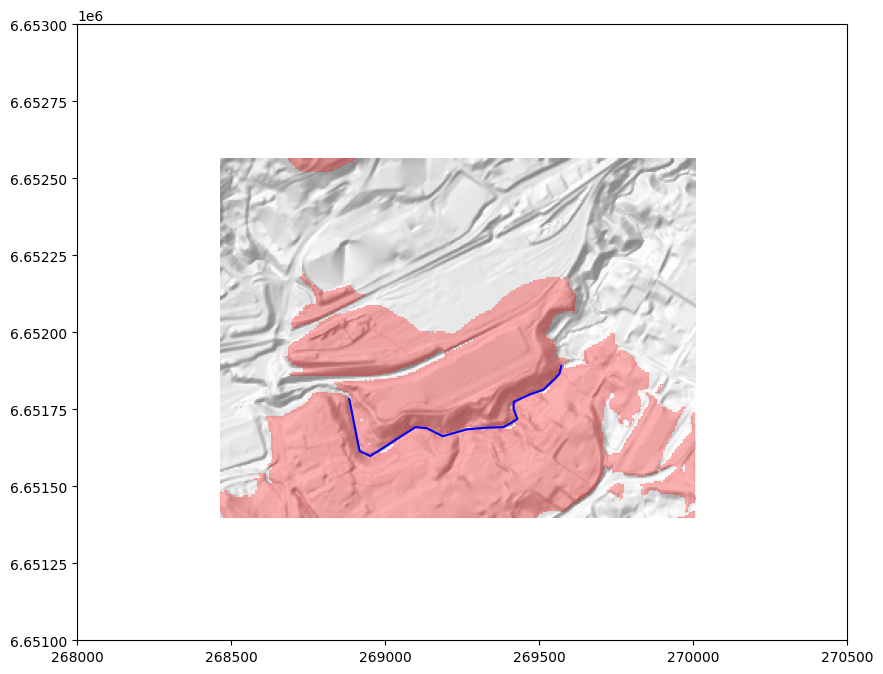

In [10]:
tc = terrain_criteria.run_terrain_criteria(bounds=(xmin, xmax, ymin, ymax),
                                           source=source_line,
                                           source_depth=0.5,
                                           clip_to_msml=True,
                                           h_min=0,
                                           
                                          )
fig, ax = plot_hillshade_with_overlay(dem_data["full_array"], dem_data["profile"]["transform"], 25833, tc, vertical_exag=2, column="slope")
source_line.plot(ax=ax, color='blue')

In [11]:
tc = terrain_criteria.run_terrain_criteria(bounds=(xmin, xmax, ymin, ymax),
                                           source=line_coords,
                                           source_depth=0.5,
                                           clip_to_msml=True,
                                           h_min=5
                                          )

<Axes: >

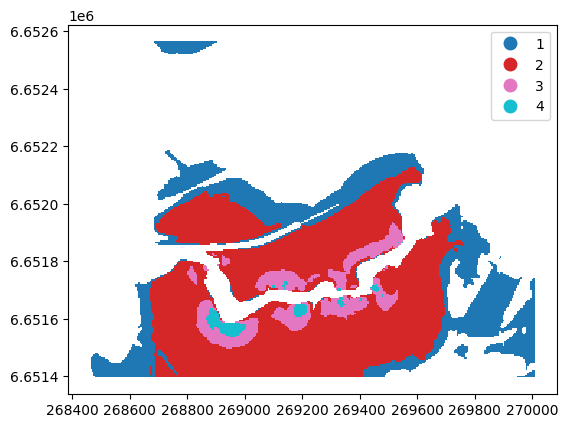

In [12]:
tc.plot(column="slope", categorical=True, legend=True)

In [13]:
tc["area"] = tc.area
tc[["slope", "area"]].groupby("slope").sum()

,area
slope,
1,213196.252541
2,421556.339126
3,61410.980112
4,9979.598487


In [86]:
# terrain criteria analysis with source as points

tc = terrain_criteria.run_terrain_criteria(bounds=(xmin, xmax, ymin, ymax),
                                           source=points,
                                           source_depth=0.5,
                                           clip_to_msml=True,
                                           h_min=5
                                          )

<Axes: >

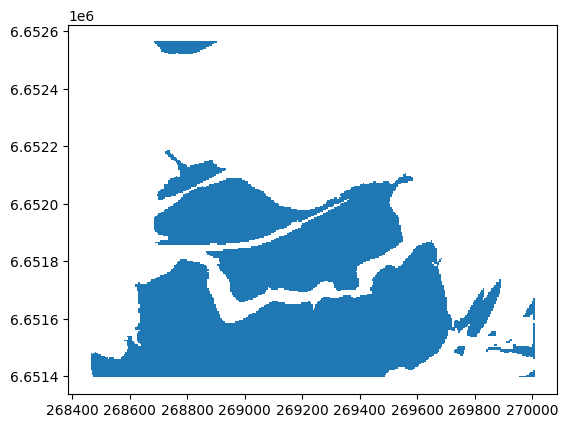

In [87]:
tc.plot()

### Retrogression computation

The slope is computed just for the neighbor pixels to the initial release points, this is done progressively until the release area is not changes from one iteration to the next.

In [65]:
retro, animation =    retrogression.run_retrogression(  bounds = (xmin,xmax,ymin,ymax),
                                                        rel_shape=source_line,
                                                        point_depth=0.5,
                                                        clip_to_msml=True,
                                                        min_slope=1/15,
                                                        min_length=75,
                                                        min_height=0,
                                                        return_animation=True,
                                                       )

runing landslide propagation...


iterations: 0it [00:00, ?it/s]

<Axes: >

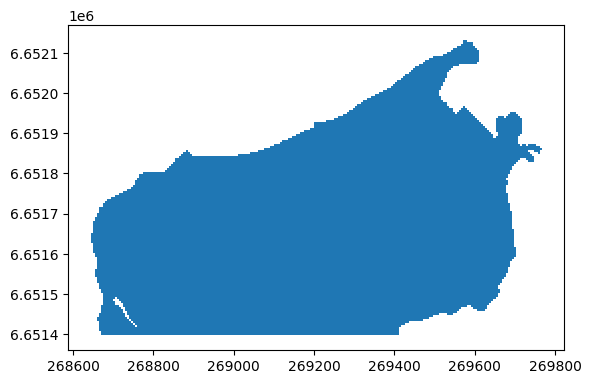

In [66]:
retro.plot()

In [25]:
dem_data = utils.get_hoydedata((xmin,xmax,ymin,ymax), )

In [1]:
# retrogression.animate_landslide_retrogresion(animation, dem_data["full_array"])

## Retrogression with initial condition on slope
This is meant to be used to assess erosion triggered quick-clay landslides, by requiring the slope of the riverbank to be above a certain threshold (1/4), and then run a retrogression analysis with 1/15 slope.

In [68]:
retro, animation =    retrogression.run_retrogression_with_initial_landslide(  
    bounds = (xmin,xmax,ymin,ymax),
 rel_shape=source_line,
 point_depth=0.5,
 clip_to_msml=True,
 ini_slope=1/4,
 retro_slope=1/15,
 min_length=20,
 min_height=0,
 return_animation=True,
)

<Axes: >

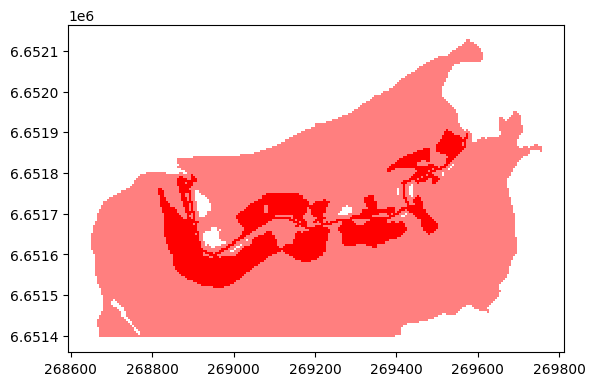

In [81]:
ax = retro.query("slope == 1/4").plot(column="slope", color="red", alpha=1)
retro.query("slope == 1/15").plot(column="slope", color="red", alpha=0.5, ax=ax)

In [2]:
# retrogression.animate_landslide_retrogresion(animation, dem_data["full_array"], frame_step=10)

In [3]:
# Initial landslide with slope 1/4

#retrogression.plot_hillshade_overlay(dem_data["full_array"], animation[91])

In [4]:
# Retrogression from the initial landslide with slope 1:15

#retrogression.plot_hillshade_overlay(dem_data["full_array"], animation[-1])